# Couple Candlesticks - Strategy - Backtesting 

### Import Library

In [40]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-07 14:15:00,1343.3,1344.4,1342.4,1344.2,5075
2025-02-07 14:20:00,1344.2,1344.7,1343.6,1344.0,4865
2025-02-07 14:25:00,1344.1,1344.2,1342.8,1343.3,5013


In [6]:
def set_condition_1(r):
    cond = ''
    if r['Open'] > r['Close'] and r['Close'] >= r['Low'] + 0.1:
        # Do va co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] and r['Close'] <= r['High'] - 0.1:
        # Xanh va co bong nen tren
        cond = 'long'
    return cond

def set_condition_2(r):
    cond = ''
    if r['Open'] > r['Close'] and r['Close'] == r['Low'] and r['Low'] < r['prev_low']:
        # Do va khong co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] and r['Close'] == r['High']  and r['High'] > r['prev_high']:
        # Xanh va khong co bong nen tren
        cond = 'long'
    return cond

def get_signal(r):
    signal = ''
    if r['condition_1'] == 'short' and r['condition_2'] == 'short':
        signal = 'short'
    elif r['condition_1'] == 'long' and r['condition_2'] == 'long':
        signal = 'long'
    return signal

In [7]:
def prepare_data(data):
    data['prev_low'] = data['Low'].shift(1)
    data['prev_high'] = data['High'].shift(1)
    data['diff_vol'] = data['Volume'] - data['Volume'].shift(1)
    data['max_5'] = data['High'].rolling(5).max()
    data['min_5'] = data['Low'].rolling(5).min()
    data['condition_1'] = data.apply(lambda r: set_condition_1(r), axis=1)
    data['condition_1'] = data['condition_1'].shift(1)
    data['condition_2'] = data.apply(lambda r: set_condition_2(r), axis=1)
    data['signal'] = data.apply(lambda r: get_signal(r), axis=1)
    # Optimnize
    data['RSI'] = ta.rsi(data["Close"], length=14)
    data['oc'] = data.apply(lambda r: r['Close'] - r['Open'], axis=1)
    data['next_oc'] = data['oc'].shift(-1)
    data['sum_2next_oc'] = data['oc'].shift(-1) + data['oc'].shift(-2)
    data['sum_5next_oc'] = data['oc'].shift(-1) + data['oc'].shift(-2) + data['oc'].shift(-3) + data['oc'].shift(-4) + data['oc'].shift(-5)
    data['body'] = data.apply(lambda r: abs(r['oc']), axis=1)
    data['ibs'] = data.apply(lambda x: (-1 if (x["High"] == x["Low"]) else (x["Close"] - x["Low"]) / (x["High"] - x["Low"])), axis=1)
    data['next_ibs'] = data['ibs'].shift(-1)
    data["vol_20_mean"] = data["Volume"].rolling(20).mean()
    data["current"] = data.index + pd.DateOffset(minutes=5)
    return data

In [8]:
class CoupleCandlesticks(Strategy):
    max_sl = 3.5
    trailing_sl = 4.5
    tp_step = 20
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
                return
                
        if current_time.hour == 14 and current_time.minute >= 30:
            return

        close_price = self.data.Close[-1]
        if self.position.is_long:
            max_5 = self.data.max_5[-1]
            if close_price < max_5 - self.trailing_sl:
                self.position.close()
        elif self.position.is_short:
            min_5 = self.data.min_5[-1]
            if close_price > min_5 + self.trailing_sl:
                self.position.close()

        if self.position:
            return 
        signal = self.data.signal[-1]
        if signal == 'long':
            buy_price = close_price
            min_5 = self.data.min_5[-1]
            tmp_risk = buy_price - min_5
            risk = min(tmp_risk, self.max_sl)
            sl = buy_price - risk
            tp = buy_price + self.tp_step
            self.buy(size=1, sl=sl, tp=tp)
        elif signal == 'short':
            sell_price = close_price
            max_5 = self.data.max_5[-1]
            tmp_risk = max_5 - sell_price
            risk = min(tmp_risk, self.max_sl)
            sl = sell_price + risk
            tp = sell_price - self.tp_step
            self.sell(size=1, sl=sl, tp=tp)

In [9]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [10]:
# prepared_data[(prepared_data.index > '2024-11-05 00:00:00') & (prepared_data.index < '2024-11-05 15:00:00')]

In [11]:
bt = Backtest(prepared_data, CoupleCandlesticks, commission=.0003, exclusive_orders=True)
stats = bt.run()
# bt.plot()
print(stats)

Start                     2020-11-02 10:35:00
End                       2025-02-07 14:10:00
Duration                   1558 days 03:35:00
Exposure Time [%]                   33.898493
Equity Final [$]                   2233.11288
Equity Peak [$]                    2255.59911
Return [%]                          48.874192
Buy & Hold Return [%]               49.332889
Return (Ann.) [%]                     9.93473
Volatility (Ann.) [%]                6.889958
Sharpe Ratio                         1.441915
Sortino Ratio                        3.160313
Calmar Ratio                         2.017636
Max. Drawdown [%]                   -4.923946
Avg. Drawdown [%]                   -0.336889
Max. Drawdown Duration      370 days 00:30:00
Avg. Drawdown Duration        5 days 22:35:00
# Trades                                 1626
Win Rate [%]                        35.362854
Best Trade [%]                       2.295959
Worst Trade [%]                     -0.920813
Avg. Trade [%]                    

In [12]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,1,30,31,906.97201,904.0,-2.97201,-0.003277,2020-11-02 14:30:00,2020-11-02 14:45:00,None,0 days 00:15:00
1,-1,37,50,907.92754,909.4,-1.47246,-0.001622,2020-11-03 09:25:00,2020-11-03 10:30:00,None,0 days 01:05:00
2,-1,91,96,907.02781,908.8,-1.77219,-0.001954,2020-11-04 09:40:00,2020-11-04 10:05:00,None,0 days 00:25:00
3,1,97,131,909.37273,912.5,3.12727,0.003439,2020-11-04 10:10:00,2020-11-04 14:25:00,None,0 days 04:15:00
4,1,225,234,906.97201,910.5,3.52799,0.003890,2020-11-06 13:45:00,2020-11-06 14:30:00,None,0 days 00:45:00
...,...,...,...,...,...,...,...,...,...,...,...
1621,1,54051,54053,1330.89915,1328.5,-2.39915,-0.001803,2025-02-04 14:20:00,2025-02-04 14:30:00,None,0 days 00:10:00
1622,1,54068,54079,1335.60056,1333.4,-2.20056,-0.001648,2025-02-05 10:05:00,2025-02-05 11:00:00,None,0 days 00:55:00
1623,-1,54090,54096,1331.20052,1332.6,-1.39948,-0.001051,2025-02-05 13:20:00,2025-02-05 13:50:00,None,0 days 00:30:00
1624,1,54097,54104,1333.90005,1335.1,1.19995,0.000900,2025-02-05 13:55:00,2025-02-05 14:30:00,None,0 days 00:35:00


In [13]:
trades = stats['_trades']

In [14]:
trades['cum_sum'] = trades['PnL'].cumsum()
X = np.array(range(0, len(trades['cum_sum'])))
Y = trades['cum_sum']

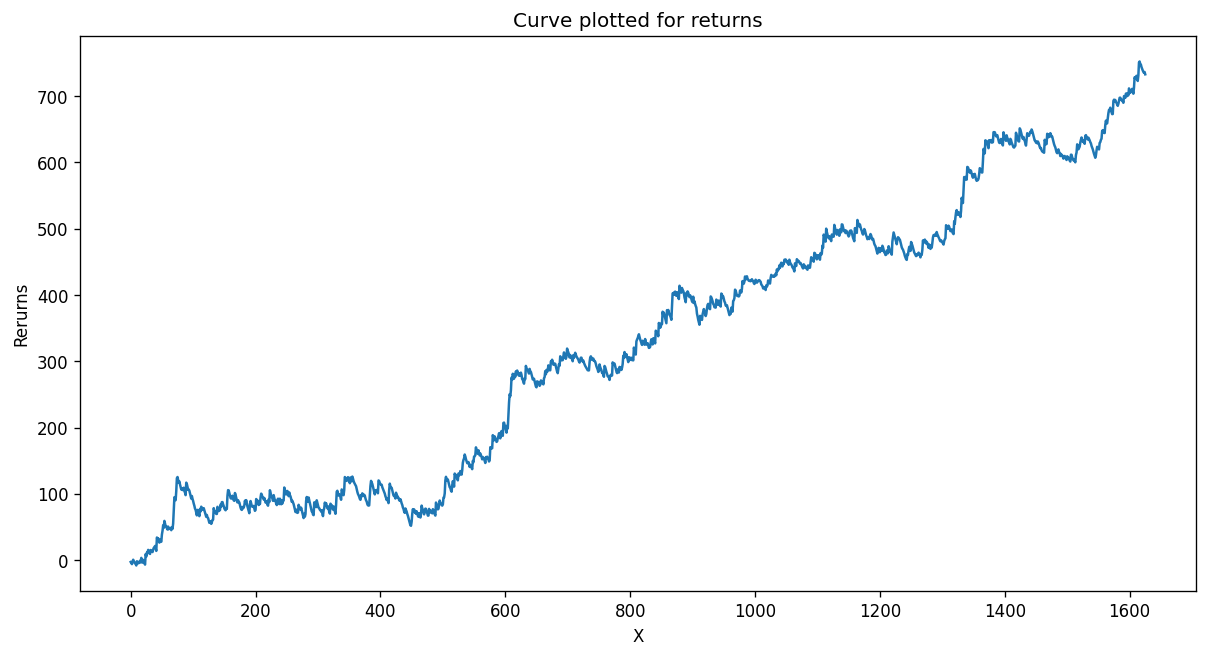

In [15]:
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

## Trades Analytics

<Axes: xlabel='hour'>

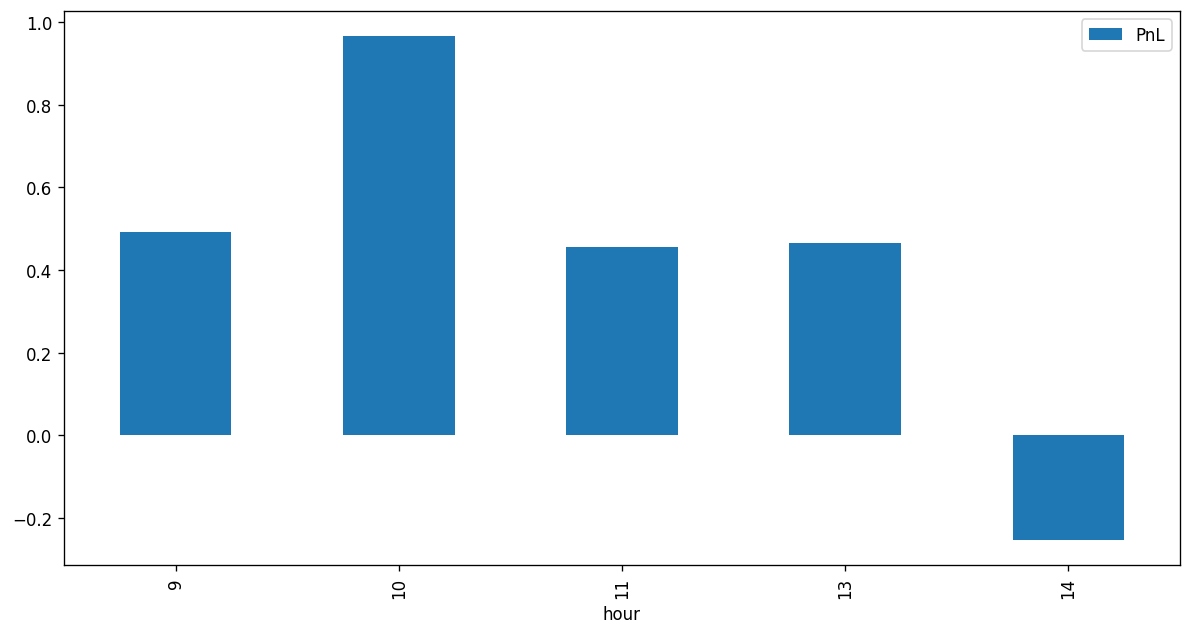

In [16]:
trades['hour'] = trades['EntryTime'].dt.hour
trades_grouped_by_hour = trades.groupby(['hour'])[['PnL']].mean()
trades_grouped_by_hour.plot.bar()

<Axes: xlabel='hour'>

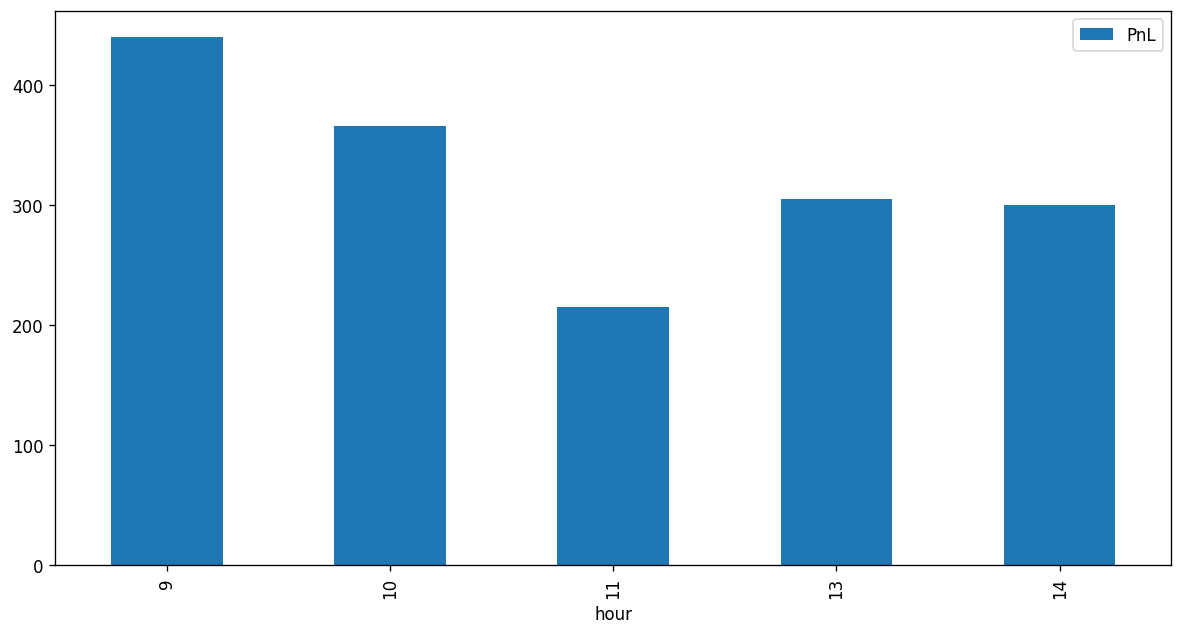

In [17]:
trades_grouped_by_hourc = trades.groupby(['hour'])[['PnL']].count()
trades_grouped_by_hourc.plot.bar()

<Axes: xlabel='day_of_week'>

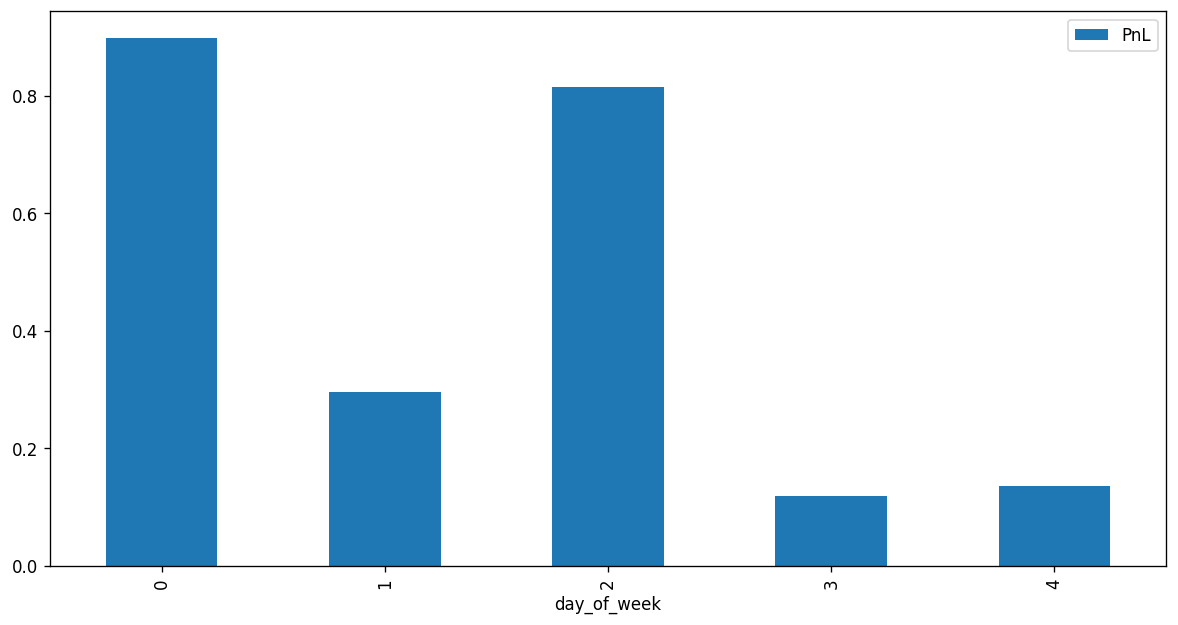

In [18]:
trades['day_of_week'] = trades['EntryTime'].dt.dayofweek
trades_grouped_by_dow = trades.groupby(['day_of_week'])[['PnL']].mean()
trades_grouped_by_dow.plot.bar()

<Axes: xlabel='day_of_week'>

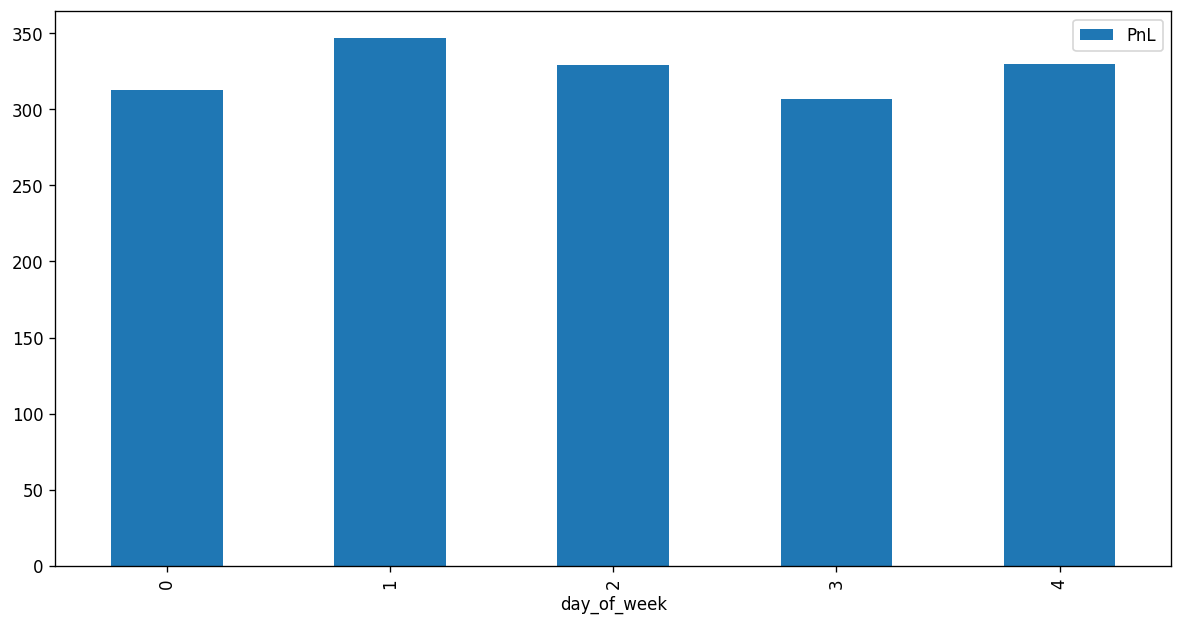

In [19]:
trades_grouped_by_dowc = trades.groupby(['day_of_week'])[['PnL']].count()
trades_grouped_by_dowc.plot.bar()

<Axes: xlabel='day_of_month'>

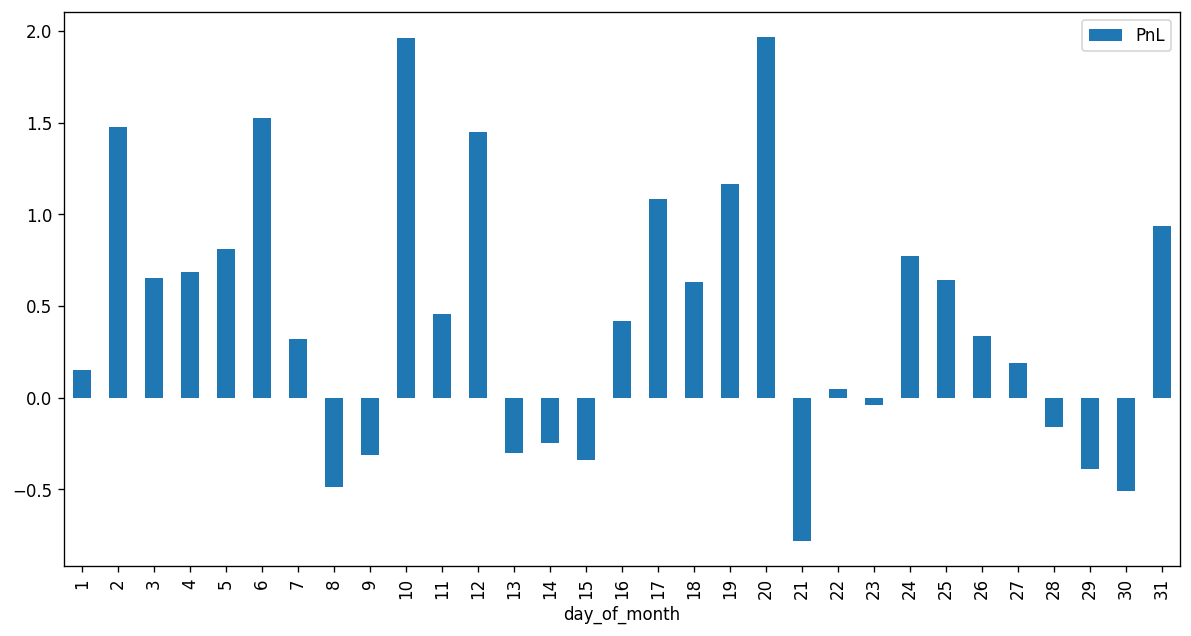

In [20]:
trades['day_of_month'] = trades['EntryTime'].dt.day
trades_grouped_by_dom = trades.groupby(['day_of_month'])[['PnL']].mean()
trades_grouped_by_dom.plot.bar()

<Axes: xlabel='day_of_month'>

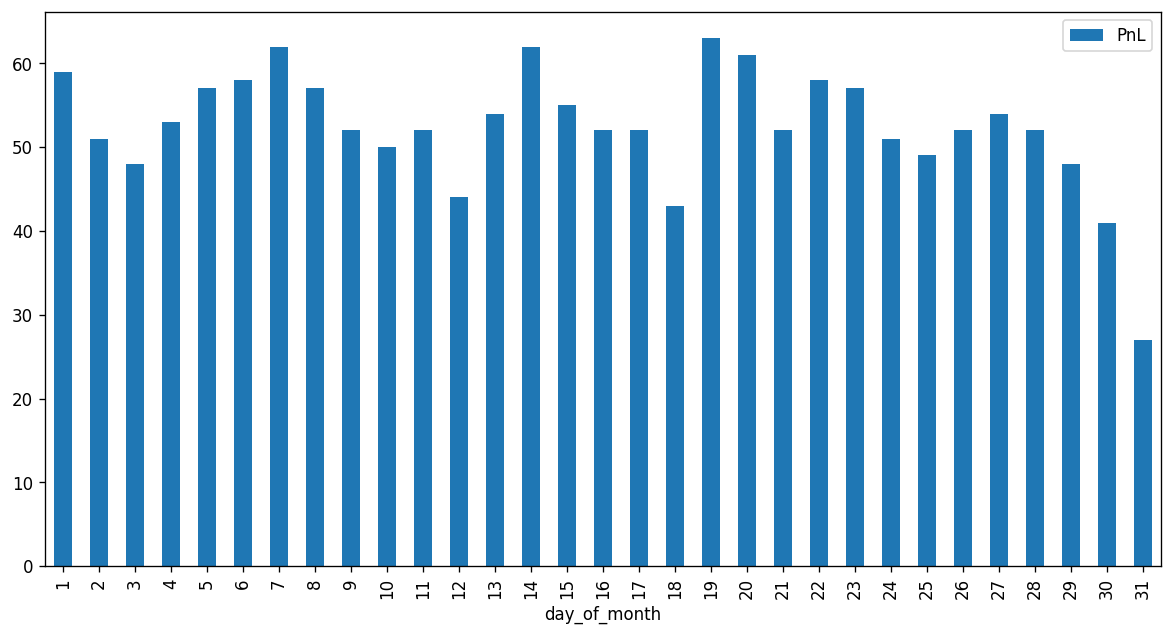

In [21]:
trades_grouped_by_domc = trades.groupby(['day_of_month'])[['PnL']].count()
trades_grouped_by_domc.plot.bar()

<Axes: xlabel='month'>

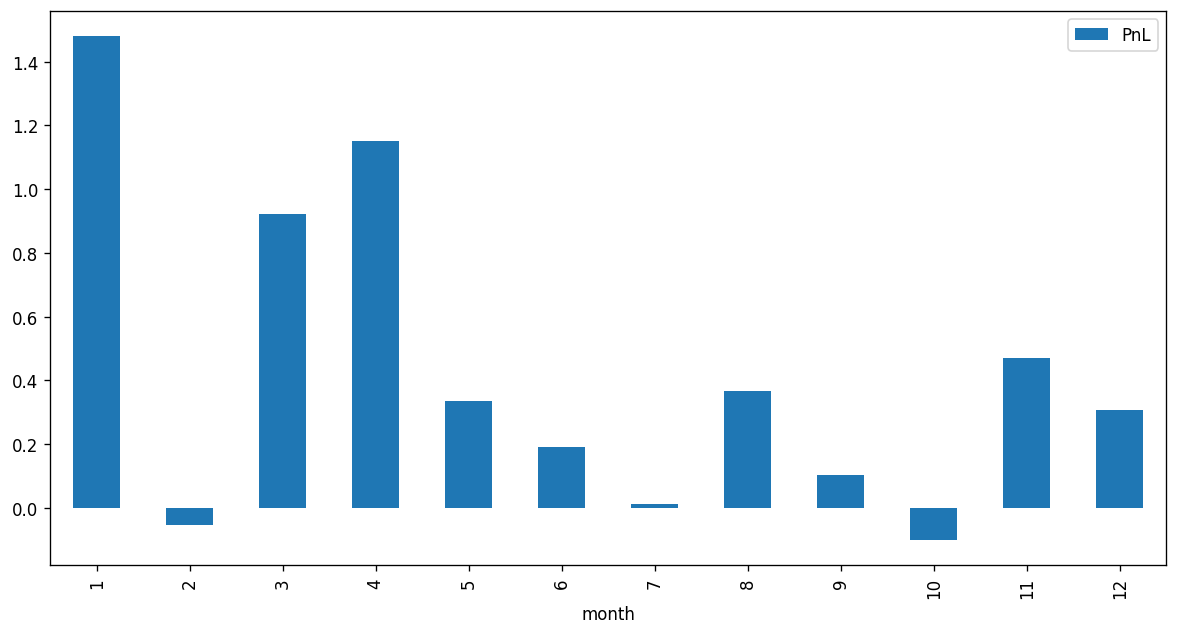

In [22]:
trades['month'] = trades['EntryTime'].dt.month
trades_grouped_by_month = trades.groupby(['month'])[['PnL']].mean()
trades_grouped_by_month.plot.bar()

<Axes: xlabel='month'>

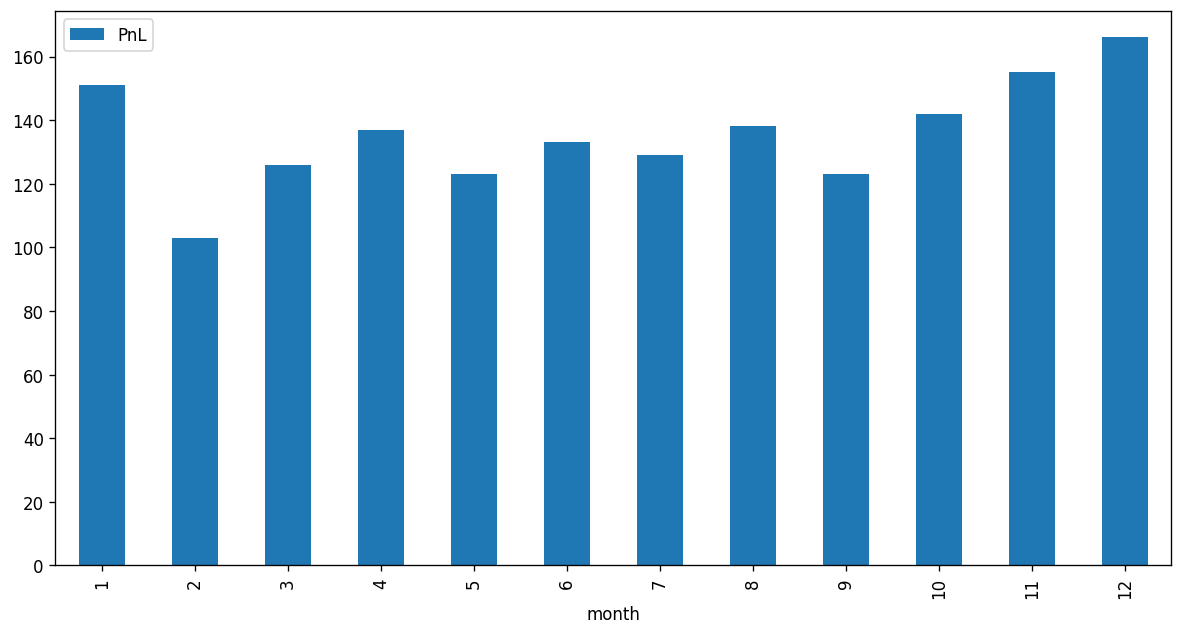

In [23]:
trades_grouped_by_month = trades.groupby(['month'])[['PnL']].count()
trades_grouped_by_month.plot.bar()

<Axes: xlabel='year'>

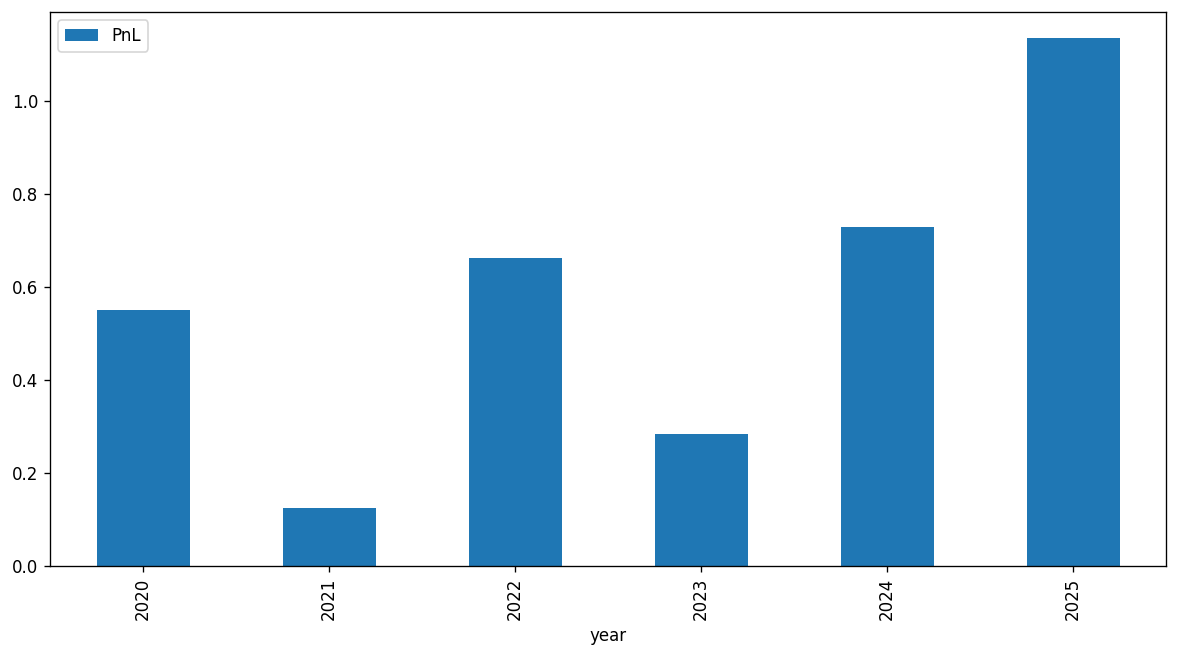

In [24]:
trades['year'] = trades['EntryTime'].dt.year
trades_grouped_by_year = trades.groupby(['year'])[['PnL']].mean()
trades_grouped_by_year.plot.bar()

<Axes: xlabel='year'>

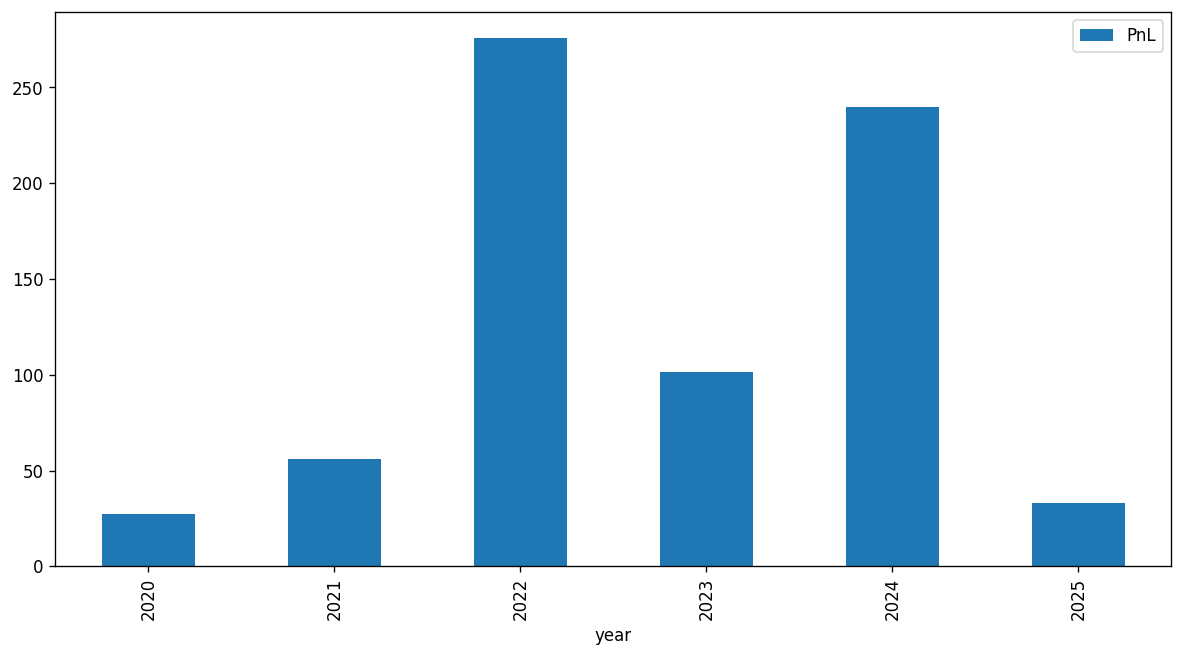

In [25]:
trades_grouped_by_years = trades.groupby(['year'])[['PnL']].sum()
trades_grouped_by_years.plot.bar()

<Axes: xlabel='year'>

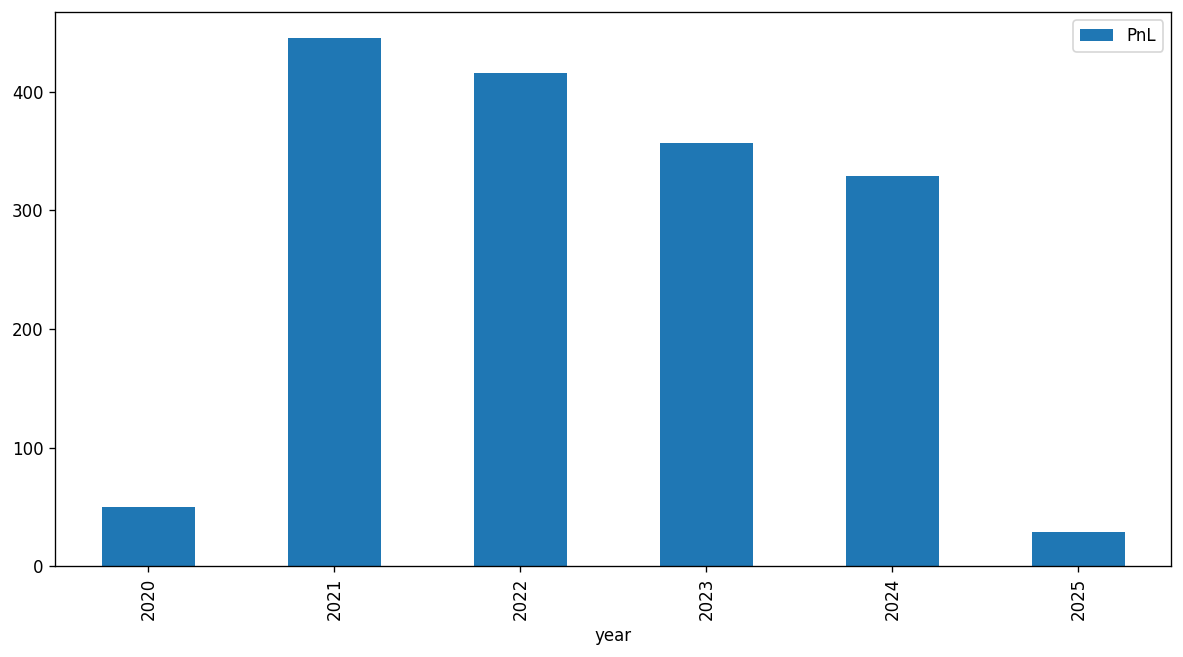

In [26]:
trades_grouped_by_yearc = trades.groupby(['year'])[['PnL']].count()
trades_grouped_by_yearc.plot.bar()

In [27]:
join_trades = pd.merge(trades, prepared_data, left_on="EntryTime", right_on='current', how="left")
join_trades

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,...,RSI,oc,next_oc,sum_2next_oc,sum_5next_oc,body,ibs,next_ibs,vol_20_mean,current
0,1,30,31,906.97201,904.0,-2.97201,-0.003277,2020-11-02 14:30:00,2020-11-02 14:45:00,None,...,68.216746,2.1,0.3,0.3,-0.2,2.1,1.0,1.000000,3485.75,2020-11-02 14:30:00
1,-1,37,50,907.92754,909.4,-1.47246,-0.001622,2020-11-03 09:25:00,2020-11-03 10:30:00,None,...,64.301187,-0.4,-0.4,-0.4,-0.4,0.4,0.0,0.111111,3346.20,2020-11-03 09:25:00
2,-1,91,96,907.02781,908.8,-1.77219,-0.001954,2020-11-04 09:40:00,2020-11-04 10:05:00,None,...,47.205851,-0.5,0.1,-0.1,1.0,0.5,0.0,0.875000,2738.40,2020-11-04 09:40:00
3,1,97,131,909.37273,912.5,3.12727,0.003439,2020-11-04 10:10:00,2020-11-04 14:25:00,None,...,57.591408,0.8,0.9,2.2,1.6,0.8,1.0,0.642857,1973.20,2020-11-04 10:10:00
4,1,225,234,906.97201,910.5,3.52799,0.003890,2020-11-06 13:45:00,2020-11-06 14:30:00,None,...,45.755965,2.2,0.8,1.3,0.5,2.2,1.0,1.000000,2473.80,2020-11-06 13:45:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,1,54051,54053,1330.89915,1328.5,-2.39915,-0.001803,2025-02-04 14:20:00,2025-02-04 14:30:00,None,...,62.556377,1.6,-1.6,-2.1,-2.6,1.6,1.0,0.192308,3038.50,2025-02-04 14:20:00
1622,1,54068,54079,1335.60056,1333.4,-2.20056,-0.001648,2025-02-05 10:05:00,2025-02-05 11:00:00,None,...,67.904840,0.8,-0.4,1.6,0.7,0.8,1.0,0.166667,3324.05,2025-02-05 10:05:00
1623,-1,54090,54096,1331.20052,1332.6,-1.39948,-0.001051,2025-02-05 13:20:00,2025-02-05 13:50:00,None,...,39.652233,-0.6,-0.1,-0.9,-1.0,0.6,0.0,0.222222,2197.90,2025-02-05 13:20:00
1624,1,54097,54104,1333.90005,1335.1,1.19995,0.000900,2025-02-05 13:55:00,2025-02-05 14:30:00,None,...,56.905957,1.5,1.2,3.2,2.6,1.5,1.0,1.000000,2507.95,2025-02-05 13:55:00


Text(0, 0.5, 'PnL')

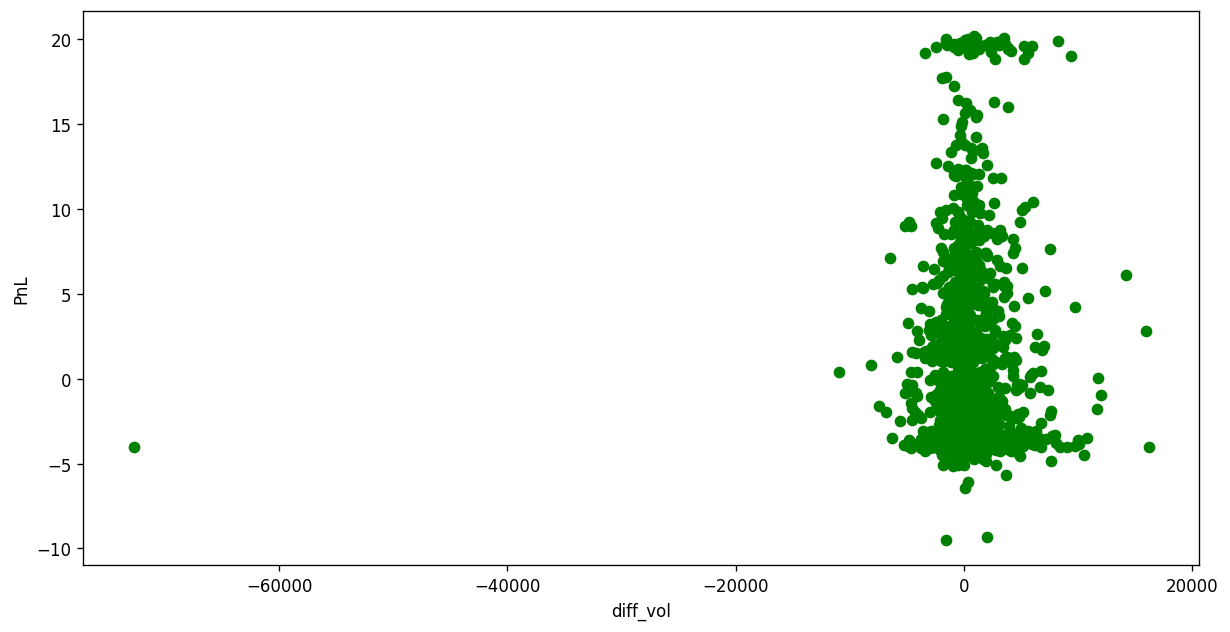

In [28]:
plt.scatter(join_trades['diff_vol'], join_trades['PnL'], color='green')
plt.xlabel("diff_vol")
plt.ylabel("PnL")

In [29]:
long_trades = join_trades[join_trades.Size==1]
short_trades = join_trades[join_trades.Size==-1]

Text(0, 0.5, 'PnL')

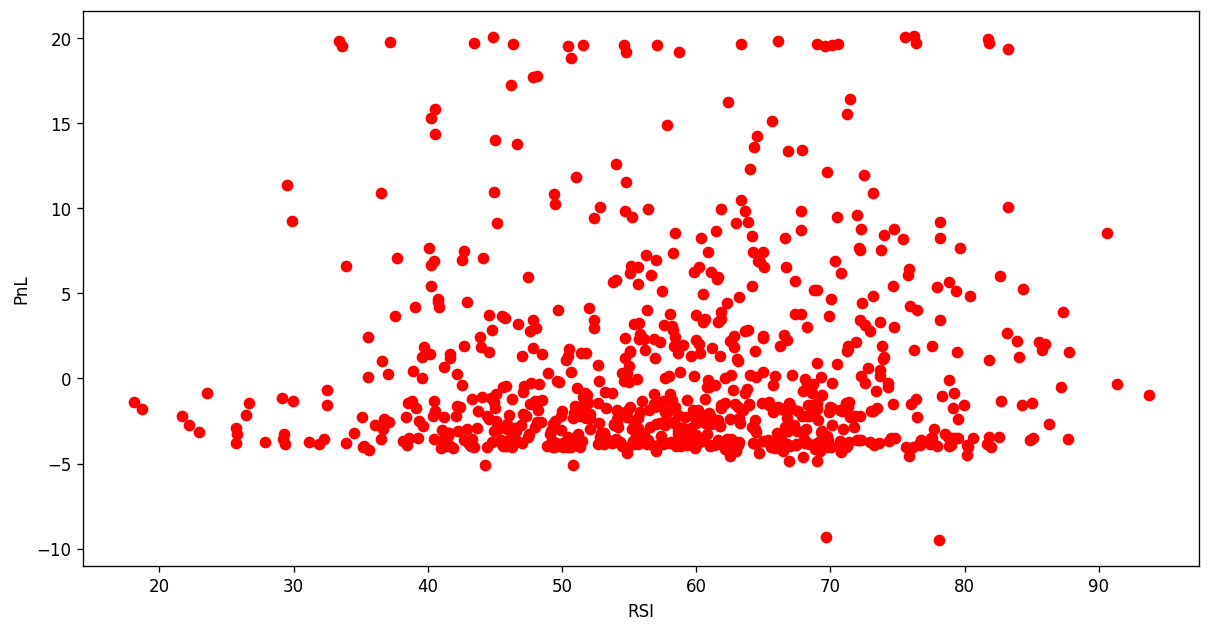

In [30]:
plt.scatter(long_trades['RSI'], long_trades['PnL'], color='red')
plt.xlabel("RSI")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

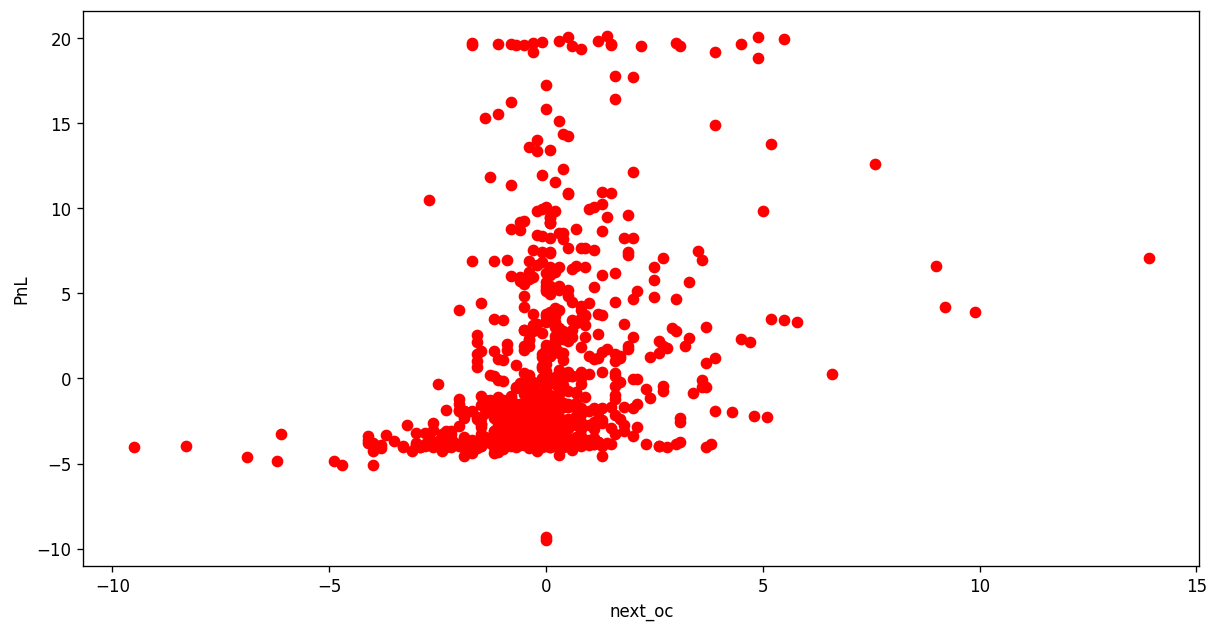

In [31]:
plt.scatter(long_trades['next_oc'], long_trades['PnL'], color='red')
plt.xlabel("next_oc")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

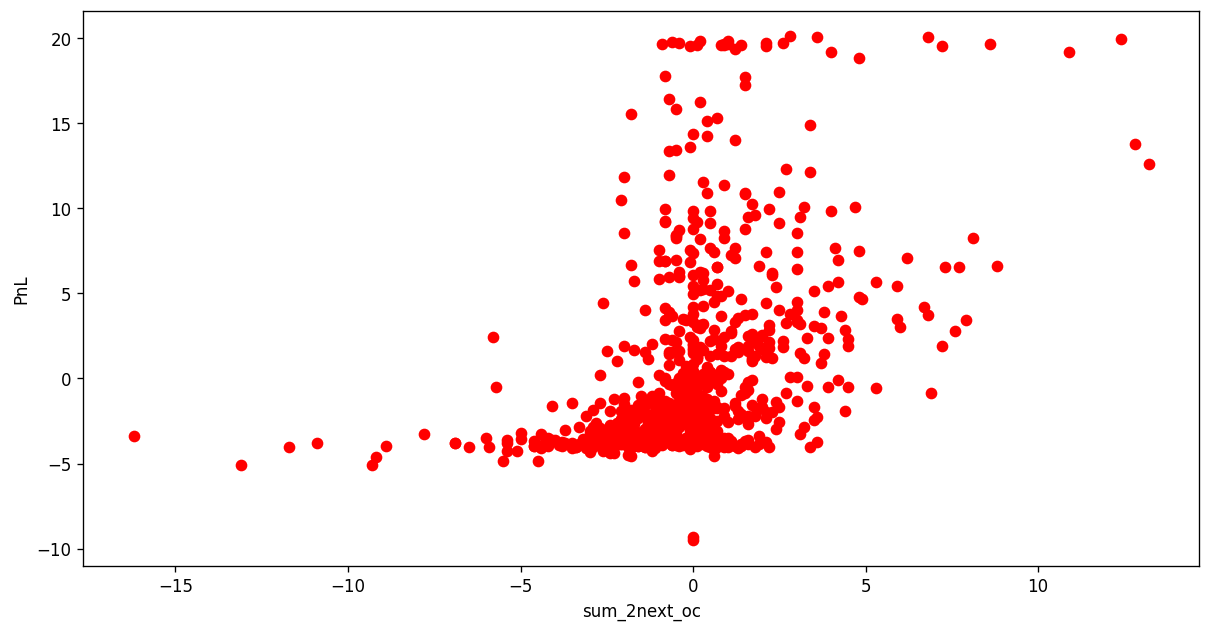

In [32]:
plt.scatter(long_trades['sum_2next_oc'], long_trades['PnL'], color='red')
plt.xlabel("sum_2next_oc")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

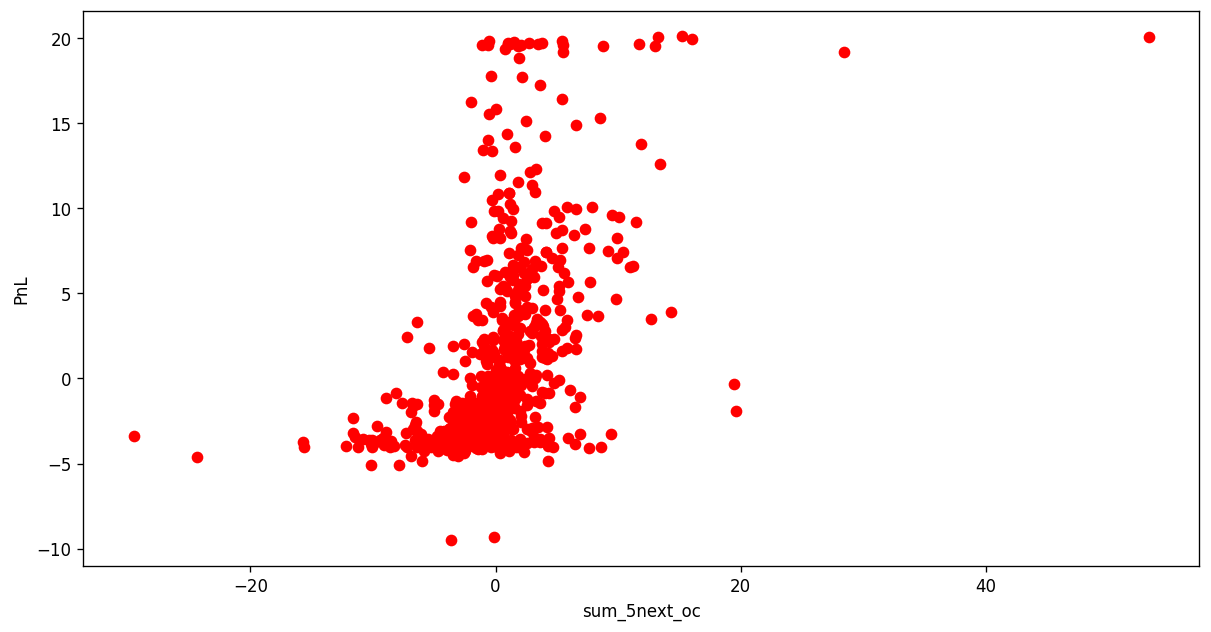

In [33]:
plt.scatter(long_trades['sum_5next_oc'], long_trades['PnL'], color='red')
plt.xlabel("sum_5next_oc")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

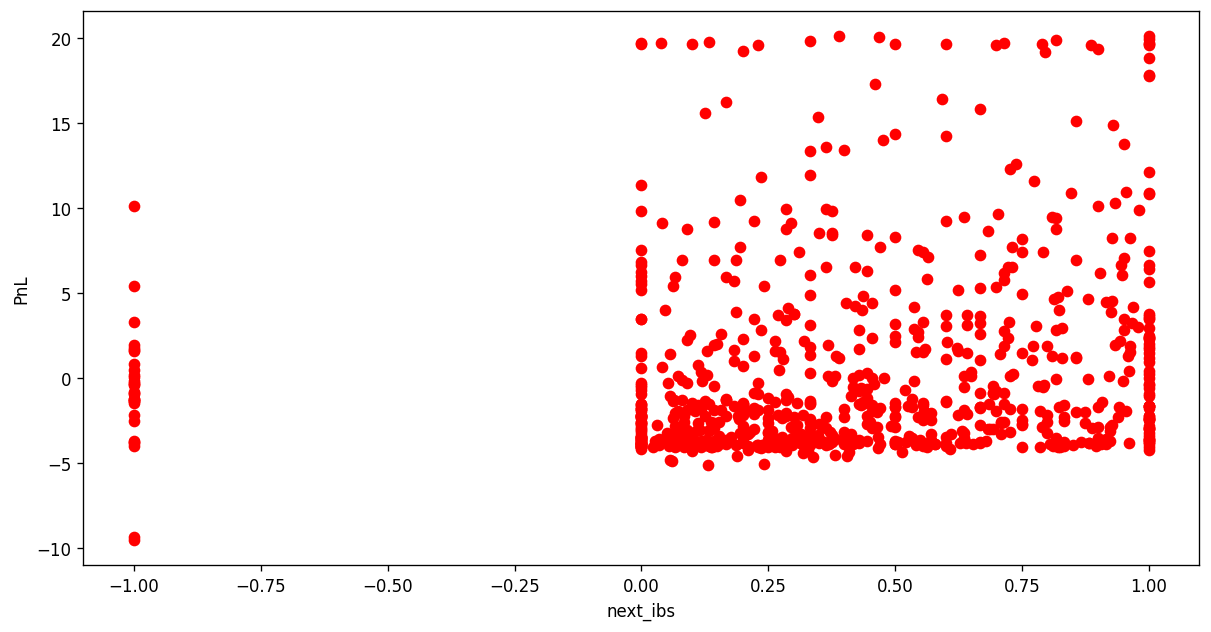

In [34]:
plt.scatter(long_trades['next_ibs'], long_trades['PnL'], color='red')
plt.xlabel("next_ibs")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

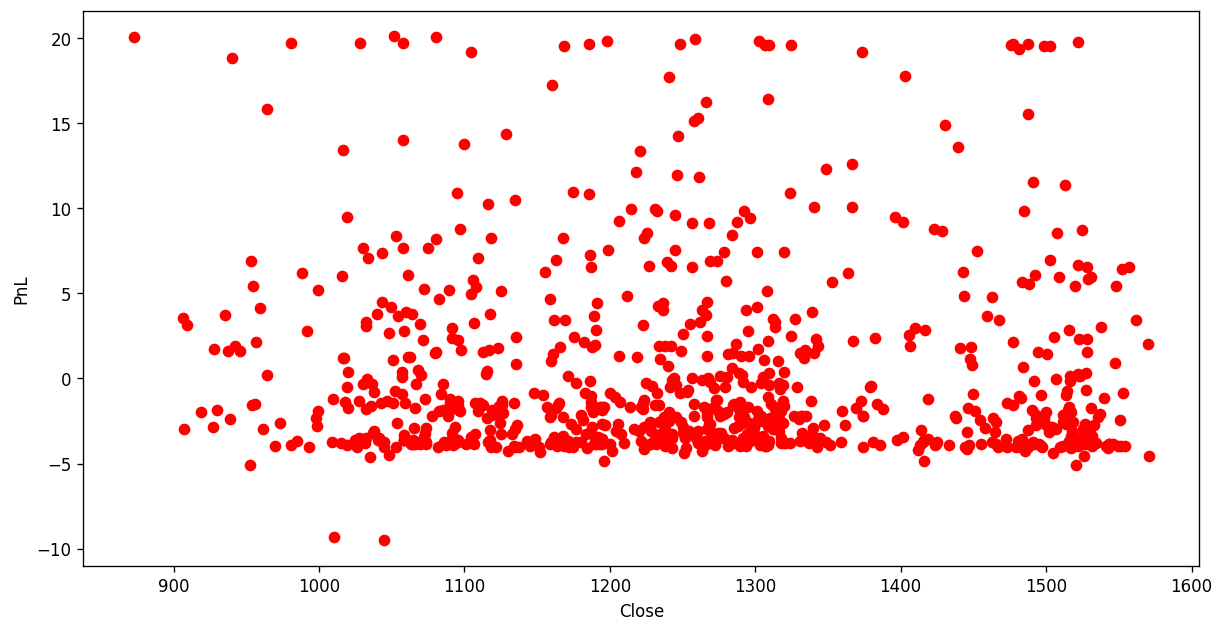

In [35]:
plt.scatter(long_trades['Close'], long_trades['PnL'], color='red')
plt.xlabel("Close")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

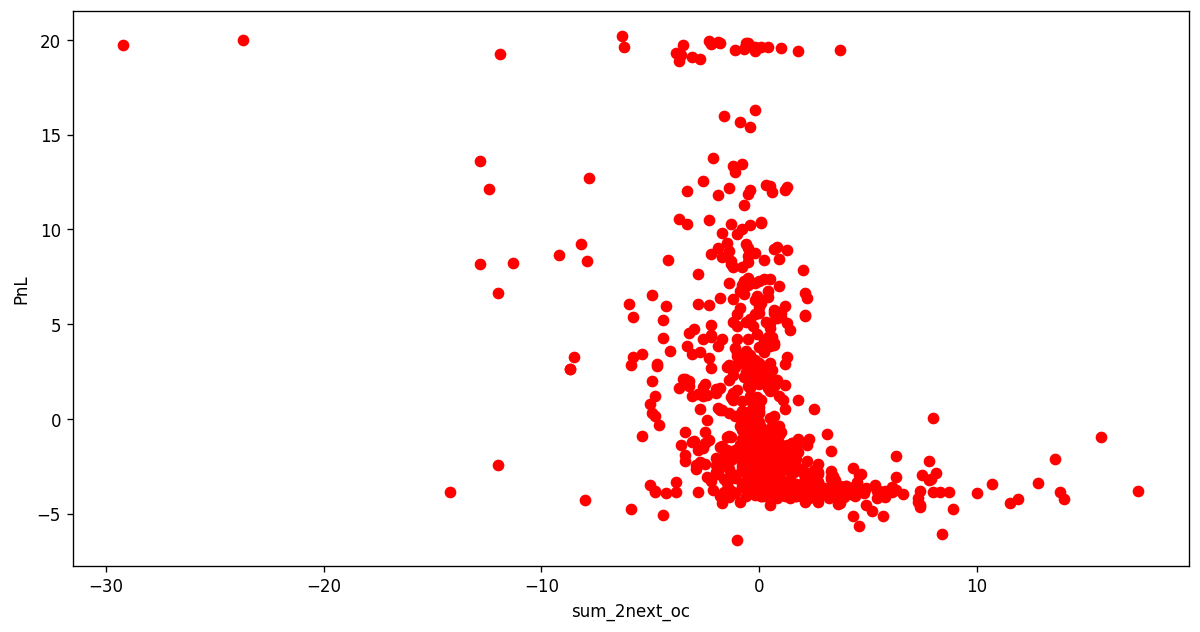

In [36]:
plt.scatter(short_trades['sum_2next_oc'], short_trades['PnL'], color='red')
plt.xlabel("sum_2next_oc")
plt.ylabel("PnL")

## Optmize params

In [37]:
max_sl_params = [x / 10.0 for x in range(20, 60, 5)]
trailing_sl_params = [x / 10.0 for x in range(20, 60, 5)]
optimize_stats, heatmap = bt.optimize(max_sl=max_sl_params,
                                      trailing_sl=trailing_sl_params,
                                        maximize='Return [%]',
                                        random_state=0,
                                        return_heatmap=True)

In [38]:
optimize_stats

Start                     2020-11-02 10:35:00
End                       2025-02-07 14:10:00
Duration                   1558 days 03:35:00
Exposure Time [%]                   33.265686
Equity Final [$]                   2324.40489
Equity Peak [$]                    2346.59112
Return [%]                          54.960326
Buy & Hold Return [%]               49.332889
Return (Ann.) [%]                   10.982941
Volatility (Ann.) [%]                 6.62899
Sharpe Ratio                         1.656805
Sortino Ratio                        3.920158
Calmar Ratio                         2.457652
Max. Drawdown [%]                   -4.468876
Avg. Drawdown [%]                   -0.370985
Max. Drawdown Duration      168 days 23:05:00
Avg. Drawdown Duration        5 days 03:44:00
# Trades                                 1635
Win Rate [%]                        32.171254
Best Trade [%]                       2.295959
Worst Trade [%]                     -0.920813
Avg. Trade [%]                    

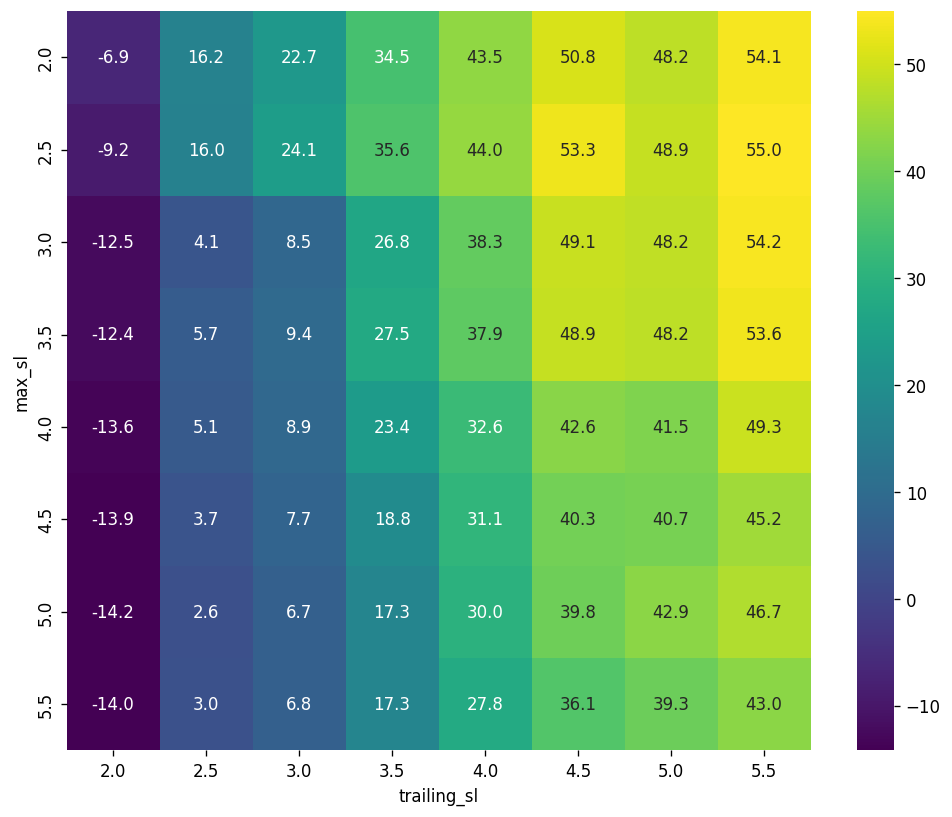

In [39]:
import seaborn as sns
# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.1f')
plt.show()